In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm #맷플롯립에서 colormap을 불러옴 : 데이터 값에 따라 색상으로 표현
#
from scipy.stats import qmc # upgrade scipy for LHS !pip install scipy --upgrade
#더 균일한 랜덤 분포를 얻는 qmc

In [3]:
tf.keras.backend.set_floatx("float64") #keras의 기본 데이터타입을 설정하는 함수 기본값: float32 -> float64(더 정확)

In [4]:
### generating data

# number of boundary and initial data points
# value `Nd` in the reference paper:
# Nd = number_of_ic_points + number_of_bc1_points + number_of_bc1_points 
N_0 = 50  #초기조건 데이터
N_b = 50 #경계조건 데이터 = N_b

# Latin Hypercube Sampling (LHS) engine ; to sample random points in domain,
# boundary and initial boundary
engine = qmc.LatinHypercube(d=1) #1차원 샘플을 만들어줄 엔진(인스턴스)생성

# temporal data points
t_d_zero = np.zeros([N_0,1])
t_d_b = engine.random(n=N_b)
t_d_b = np.pi * t_d_b
# spatial data points
x_d_zero = engine.random(n=N_0)
x_d_zero = 10 * (x_d_zero - 0.5) #기본적으로 qmc는 0,1 사이의 난수를 생성 하므로 -5,5 범위로 난수 스케일링

x_d_five = 5 * np.ones([N_b,1])
x_d_mfive = -5 * np.ones([N_b,1])
#나중에 t_d, x_d를 합칠거니 이렇게 생성했고, 앞 50개는 초기조건, 뒤 50개는 경계조건 데이터

Text(0.5, 1.0, 'Data points (BCs & IC)')

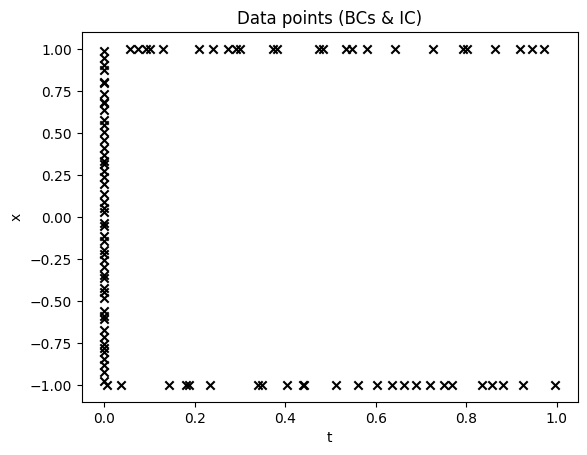

In [11]:
# view randomly sampled boundary and initial points
plt.scatter(t_d, x_d, marker="x", c="k")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Data points (BCs & IC)")

In [ ]:
# output values for data points (boundary and initial)
u_d_zero = np.zeros(x_d_zero.shape) #initializing the array y_d
v_d_zero = np.zeros(x_d_zero.shape) #done

# for initial condition: IC = -sin(pi*x)
u_d_zero = 2/(np.cosh(x_d_zero)) #앞의 50개의 데이터인 초기조건 데이터들에 대한 함수값을 초기조건에 맞게설정

In [7]:
# number of collocation points
N_f = 20000

# LHS for collocation points
engine = qmc.LatinHypercube(d=2)
data = engine.random(n=N_f)
# set x values between -1. and +1.
data[:, 1] = 10*(data[:, 1]-0.5) #x값들이 도메인 안에 들어가도록 스케일링

# change names #t,x데이터들 분리하기.
t_c = np.expand_dims(data[:, 0], axis=1)
x_c = np.expand_dims(data[:, 1], axis=1)

In [8]:
# convert all data and collocation points to tf.Tensor
t_d_zero, t_d_b, x_d_zero, x_d_five, x_d_mfive,u_d_zero, v_d_zero = map(tf.convert_to_tensor, [t_d_zero, t_d_b, x_d_zero, x_d_five, x_d_mfive,u_d_zero, v_d_zero])

In [10]:
### model design
#
neuron_per_layer = 100
# activation function for all hidden layers
actfn = "tanh"

# input layer
input_layer = tf.keras.layers.Input(shape=(2,)) #[a,b]형태의 입력값이 들어간다 즉 두개의 feature을 가지는 데이터를 입력시키는것.

# hidden layer
# also a for loop could be used instead of multiple lines of code
hidden0 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)
hidden1 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden0)
hidden2 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden1)
hidden3 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden2)
hidden4 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden3)
hidden5 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden4)


# output layer
output_layer = tf.keras.layers.Dense(2, activation=None)(hidden5)

model = tf.keras.Model(input_layer, output_layer) #입력층과 출력층만 지정하면 되는이유: tf는 자동으로 레이어 간 연결을 추적하기 때문

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,002 (398.45 KB)

 Trainable params: 51,002 (398.45 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# u(t, x) just makes working with model easier and the whole code looks more
# like its mathematical backend
@tf.function
def u(t, x):
    """
    u(t, x): 모델 출력의 첫 번째 값
    """
    inputs = tf.concat([t, x], axis=1)  # [t, x] 결합
    uv = model(inputs)  # 모델 실행
    u = uv[:, 0:1]  # 첫 번째 출력
    return u


#즉 함숫값을 반환하는 함수

In [12]:
@tf.function
def v(t, x):
    """
    v(t, x): 모델 출력의 두 번째 값
    """
    inputs = tf.concat([t, x], axis=1)  # [t, x] 결합
    uv = model(inputs)  # 모델 실행
    v = uv[:, 1:2]  # 두 번째 출력
    return v

In [22]:
# the physics informed loss function
# IMPORTANT: this loss function is used for collocation points
@tf.function
def f_u(t, x):    
    u0 = u(t, x)
    v0 = v(t,x)
    u_t = tf.gradients(u0, t)[0]
    v_x = tf.gradients(v0, x)[0]
    v_xx = tf.gradients(v_x, x)[0]
    F_u = u_t +0.5*v_xx+(u0**2+v0**2)*v0
    return tf.reduce_mean(tf.square(F_u)) #MSE_f 반환  
#텐서플로우 1에서 주로 사용하는 gradient 메소드를 이용해서 미분 구현

In [29]:
@tf.function
def f_v(t, x):    
    u0 = u(t, x)
    v0 = v(t,x)
    v_t = tf.gradients(v0, t)[0]
    u_x = tf.gradients(v0, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    F_v = -v_t +0.5*u_xx+(u0**2+v0**2)*v0
    return tf.reduce_mean(tf.square(F_v)) #MSE_f 반환  

In [24]:
# MSE loss function
# IMPORTANT: this loss function is used for data points
@tf.function
def mse(y, y_):
    
    return tf.reduce_mean(tf.square(y-y_))  #MSE_y 반환

In [32]:
@tf.function
def mse_b_u(five, mfive, t):
    u0_five = u(t, five)
    u_x_five = tf.gradients(u0_five,five)[0]
    u0_mfive = u(t,mfive)
    u_x_mfive =tf.gradients(u0_mfive,mfive)[0]
    f=u_x_five - u_x_mfive
    return tf.reduce_mean(tf.square(f))
    

In [33]:
@tf.function
def mse_b_v(five, mfive, t):
    v0_five = v(t, five)
    v_x_five = tf.gradients(v0_five,five)[0]
    v0_mfive = u(t,mfive)
    v_x_mfive =tf.gradients(v0_mfive,mfive)[0]
    f=v_x_five - v_x_mfive
    return tf.reduce_mean(tf.square(f))

In [27]:
import time #경과시간 측정을 위한 모듈 호출

In [35]:
"""
BENCHMARK on Google Colab GPU

learning_rate = 5e-4
epochs = 2000
training time ~ 85.60 s
final loss = 0.006
"""

epochs = 2000 #epochs : 반복횟수
loss_list = []

# L-BFGS optimizer was used in the reference paper
opt = tf.keras.optimizers.Adam(learning_rate=5e-4) 
start = time.time()

# training loop
# IMPORTANT: a while-based training loop is more beneficial
# updates the model while loss > 0.006
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # model output/prediction!
        y_0_u_pred = u(t_d_zero, x_d_zero)
        y_0_v_pred = v(t_d_zero, x_d_zero)
        y_b_five_u_pred = u(t_d_b,x_d_five)
        y_b_mfive_u_pred = u(t_d_b, x_d_mfive)
        y_b_five_v_pred = v(t_d_b,x_d_five)
        y_b_mfive_v_pred = v(t_d_b, x_d_mfive)
        # physics-informed loss for collocation points
        L1 = f_u(t_c, x_c)
        L2 = f_v(t_c, x_c)
        L3 = mse(u_d_zero,y_0_u_pred)
        L4 = mse(v_d_zero,y_0_v_pred)
        L5 = mse(y_b_five_u_pred,y_b_mfive_u_pred)
        L6 = mse(y_b_five_v_pred,y_b_mfive_v_pred)
        L7 = mse_b_u(x_d_five,x_d_mfive,t_d_b)
        L8 = mse_b_v(x_d_five,x_d_mfive,t_d_b)
        loss = L1 + L2 + L3 + L4 + L5 + L6 + L7 + L8
    # compute gradients
    g = tape.gradient(loss, model.trainable_weights)
    loss_list.append(loss)
    # log every 10 epochs
    if (not epoch%10) or (epoch == epochs-1):
        print(f"{epoch:4} {loss.numpy():.3f}")
    # apply gradients
    opt.apply_gradients(zip(g, model.trainable_weights))

end = time.time()
print(f"{end - start:.3} (s)")

   0 0.911
  10 0.462
  20 0.355
  30 0.304
  40 0.248
  50 0.170
  60 0.080
  70 0.022
  80 0.008
  90 0.006
 100 0.005
 110 0.004
 120 0.003
 130 0.005
 140 0.004
 150 0.003
 160 0.002
 170 0.005
 180 0.005
 190 0.002
 200 0.002
 210 0.002
 220 0.002
 230 0.002
 240 0.007
 250 0.005
 260 0.002
 270 0.001
 280 0.002
 290 0.001
 300 0.001
 310 0.001
 320 0.005
 330 0.007
 340 0.003
 350 0.002
 360 0.001
 370 0.001
 380 0.001
 390 0.001
 400 0.001
 410 0.001
 420 0.001
 430 0.001
 440 0.002
 450 0.001
 460 0.004
 470 0.001
 480 0.001
 490 0.001
 500 0.001
 510 0.001
 520 0.001
 530 0.001
 540 0.001
 550 0.001
 560 0.001
 570 0.001
 580 0.001
 590 0.001
 600 0.001
 610 0.001
 620 0.001
 630 0.001
 640 0.001
 650 0.001
 660 0.002
 670 0.004
 680 0.001
 690 0.001
 700 0.001
 710 0.001
 720 0.001
 730 0.001
 740 0.001
 750 0.001
 760 0.001
 770 0.001
 780 0.001
 790 0.000
 800 0.000
 810 0.000
 820 0.000
 830 0.000
 840 0.000
 850 0.000
 860 0.000
 870 0.000
 880 0.000
 890 0.000
 900 0.000

Text(0.5, 0, 'epoch')

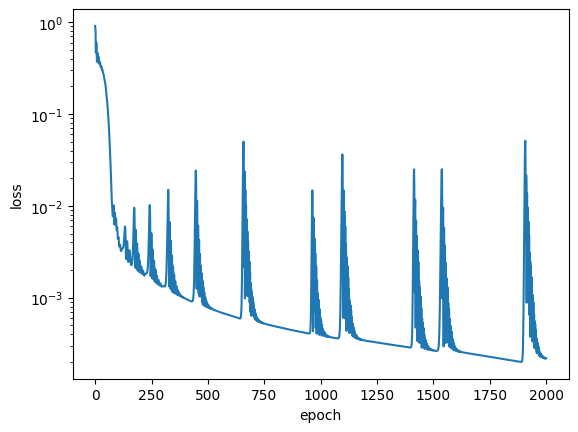

In [36]:
plt.semilogy(range(epochs), loss_list)
plt.ylabel("loss")
plt.xlabel("epoch")

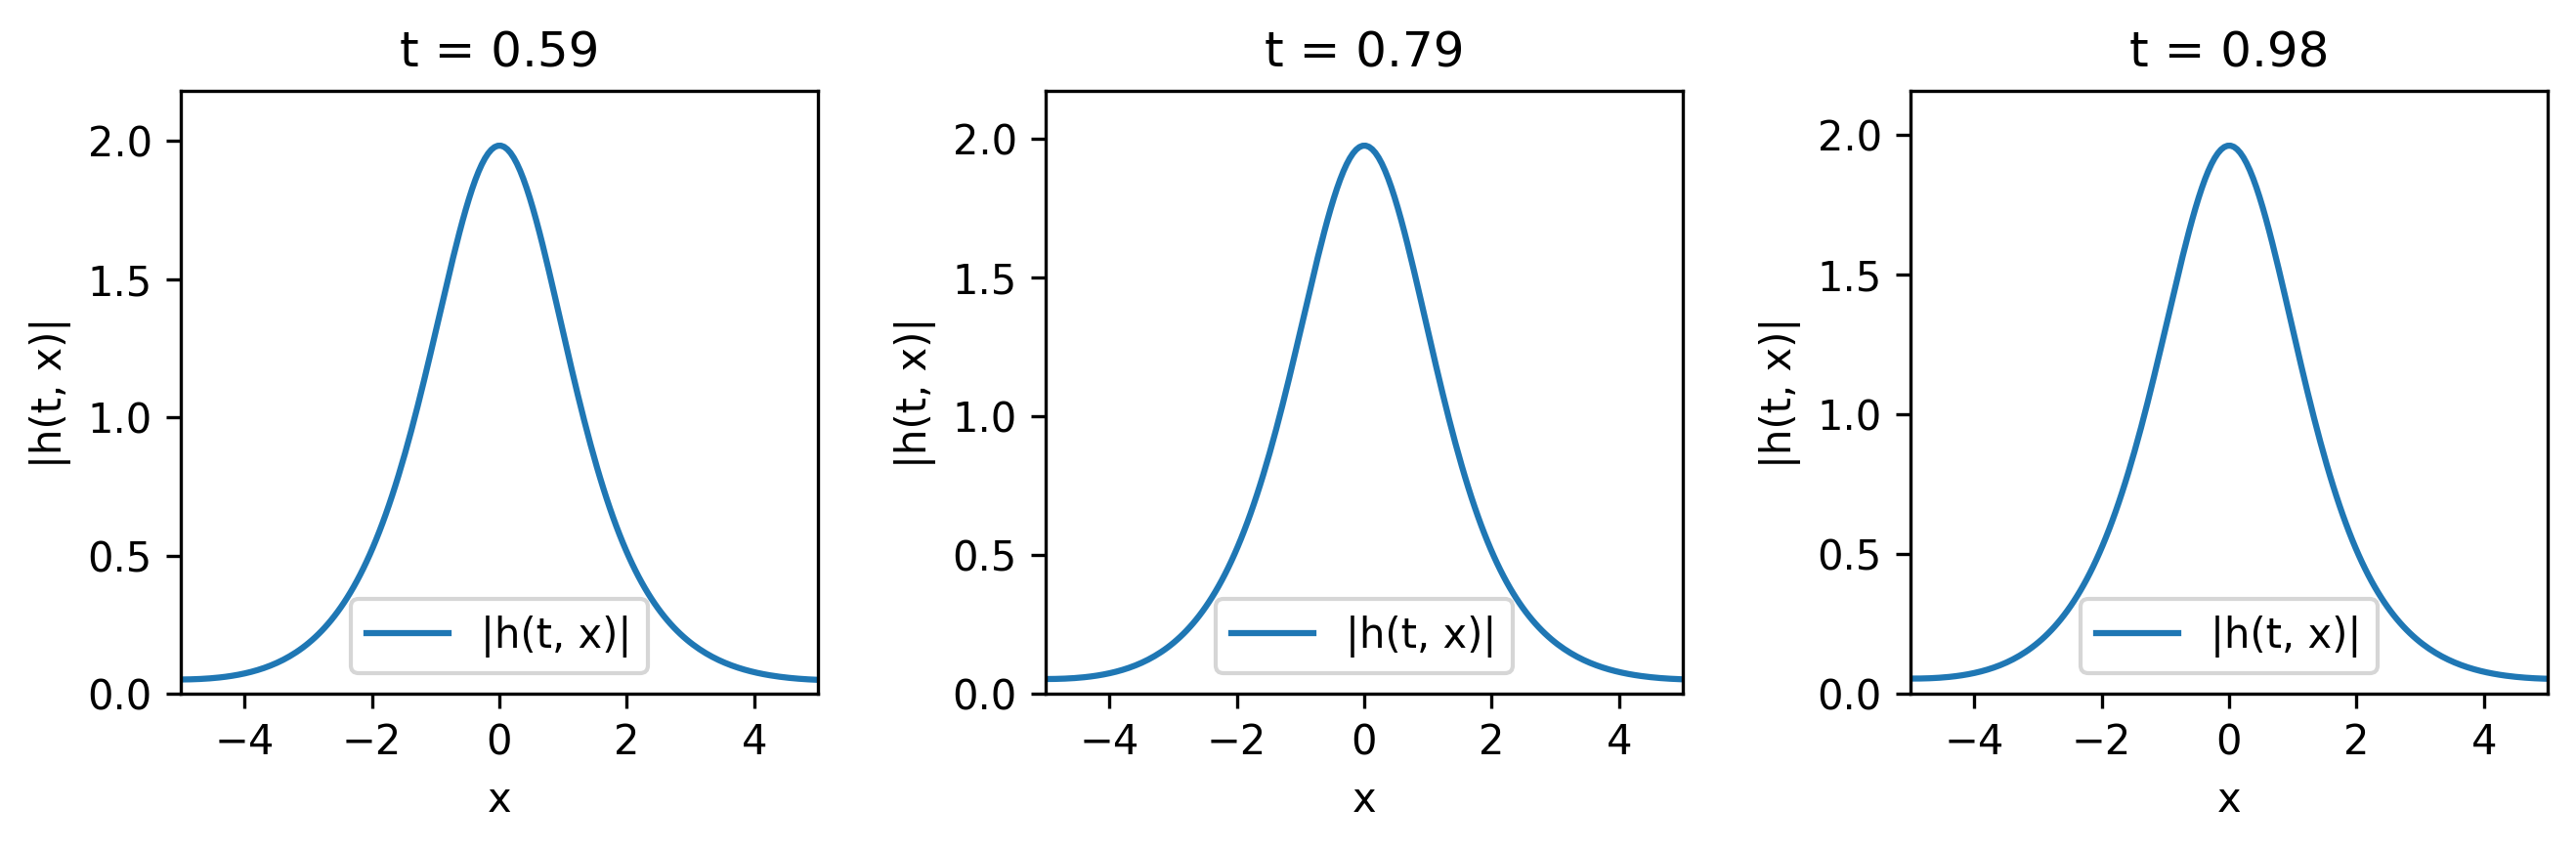

In [39]:
x = np.expand_dims(np.linspace(-5, +5, 200), axis=1)  # x 범위: -5에서 5까지

plt.figure(figsize=(9, 3), dpi=300)

# 정의된 t 값
time_points = [0.59, 0.79, 0.98]

for i, time_point in enumerate(time_points, start=1):
    t = np.ones_like(x) * time_point  # t 값 생성
    u_values = u(t, x).numpy()       # u(t, x) 계산
    v_values = v(t, x).numpy()       # v(t, x) 계산
    h_abs = np.sqrt(u_values**2 + v_values**2)  # |h(t, x)| 계산
    
    plt.subplot(1, 3, i)
    plt.title(f"t = {time_point}")
    plt.plot(x, h_abs, label="|h(t, x)|")
    plt.ylabel(f"|h(t, x)|")
    plt.xlabel(f"x")
    plt.xlim(-5, +5)  # x 범위를 -5에서 5로 설정
    plt.ylim(0, max(h_abs) * 1.1)  # y 축은 데이터 값보다 약간 크게 설정
    plt.legend()

plt.tight_layout()
plt.savefig("h-vs-x.png")
plt.show()


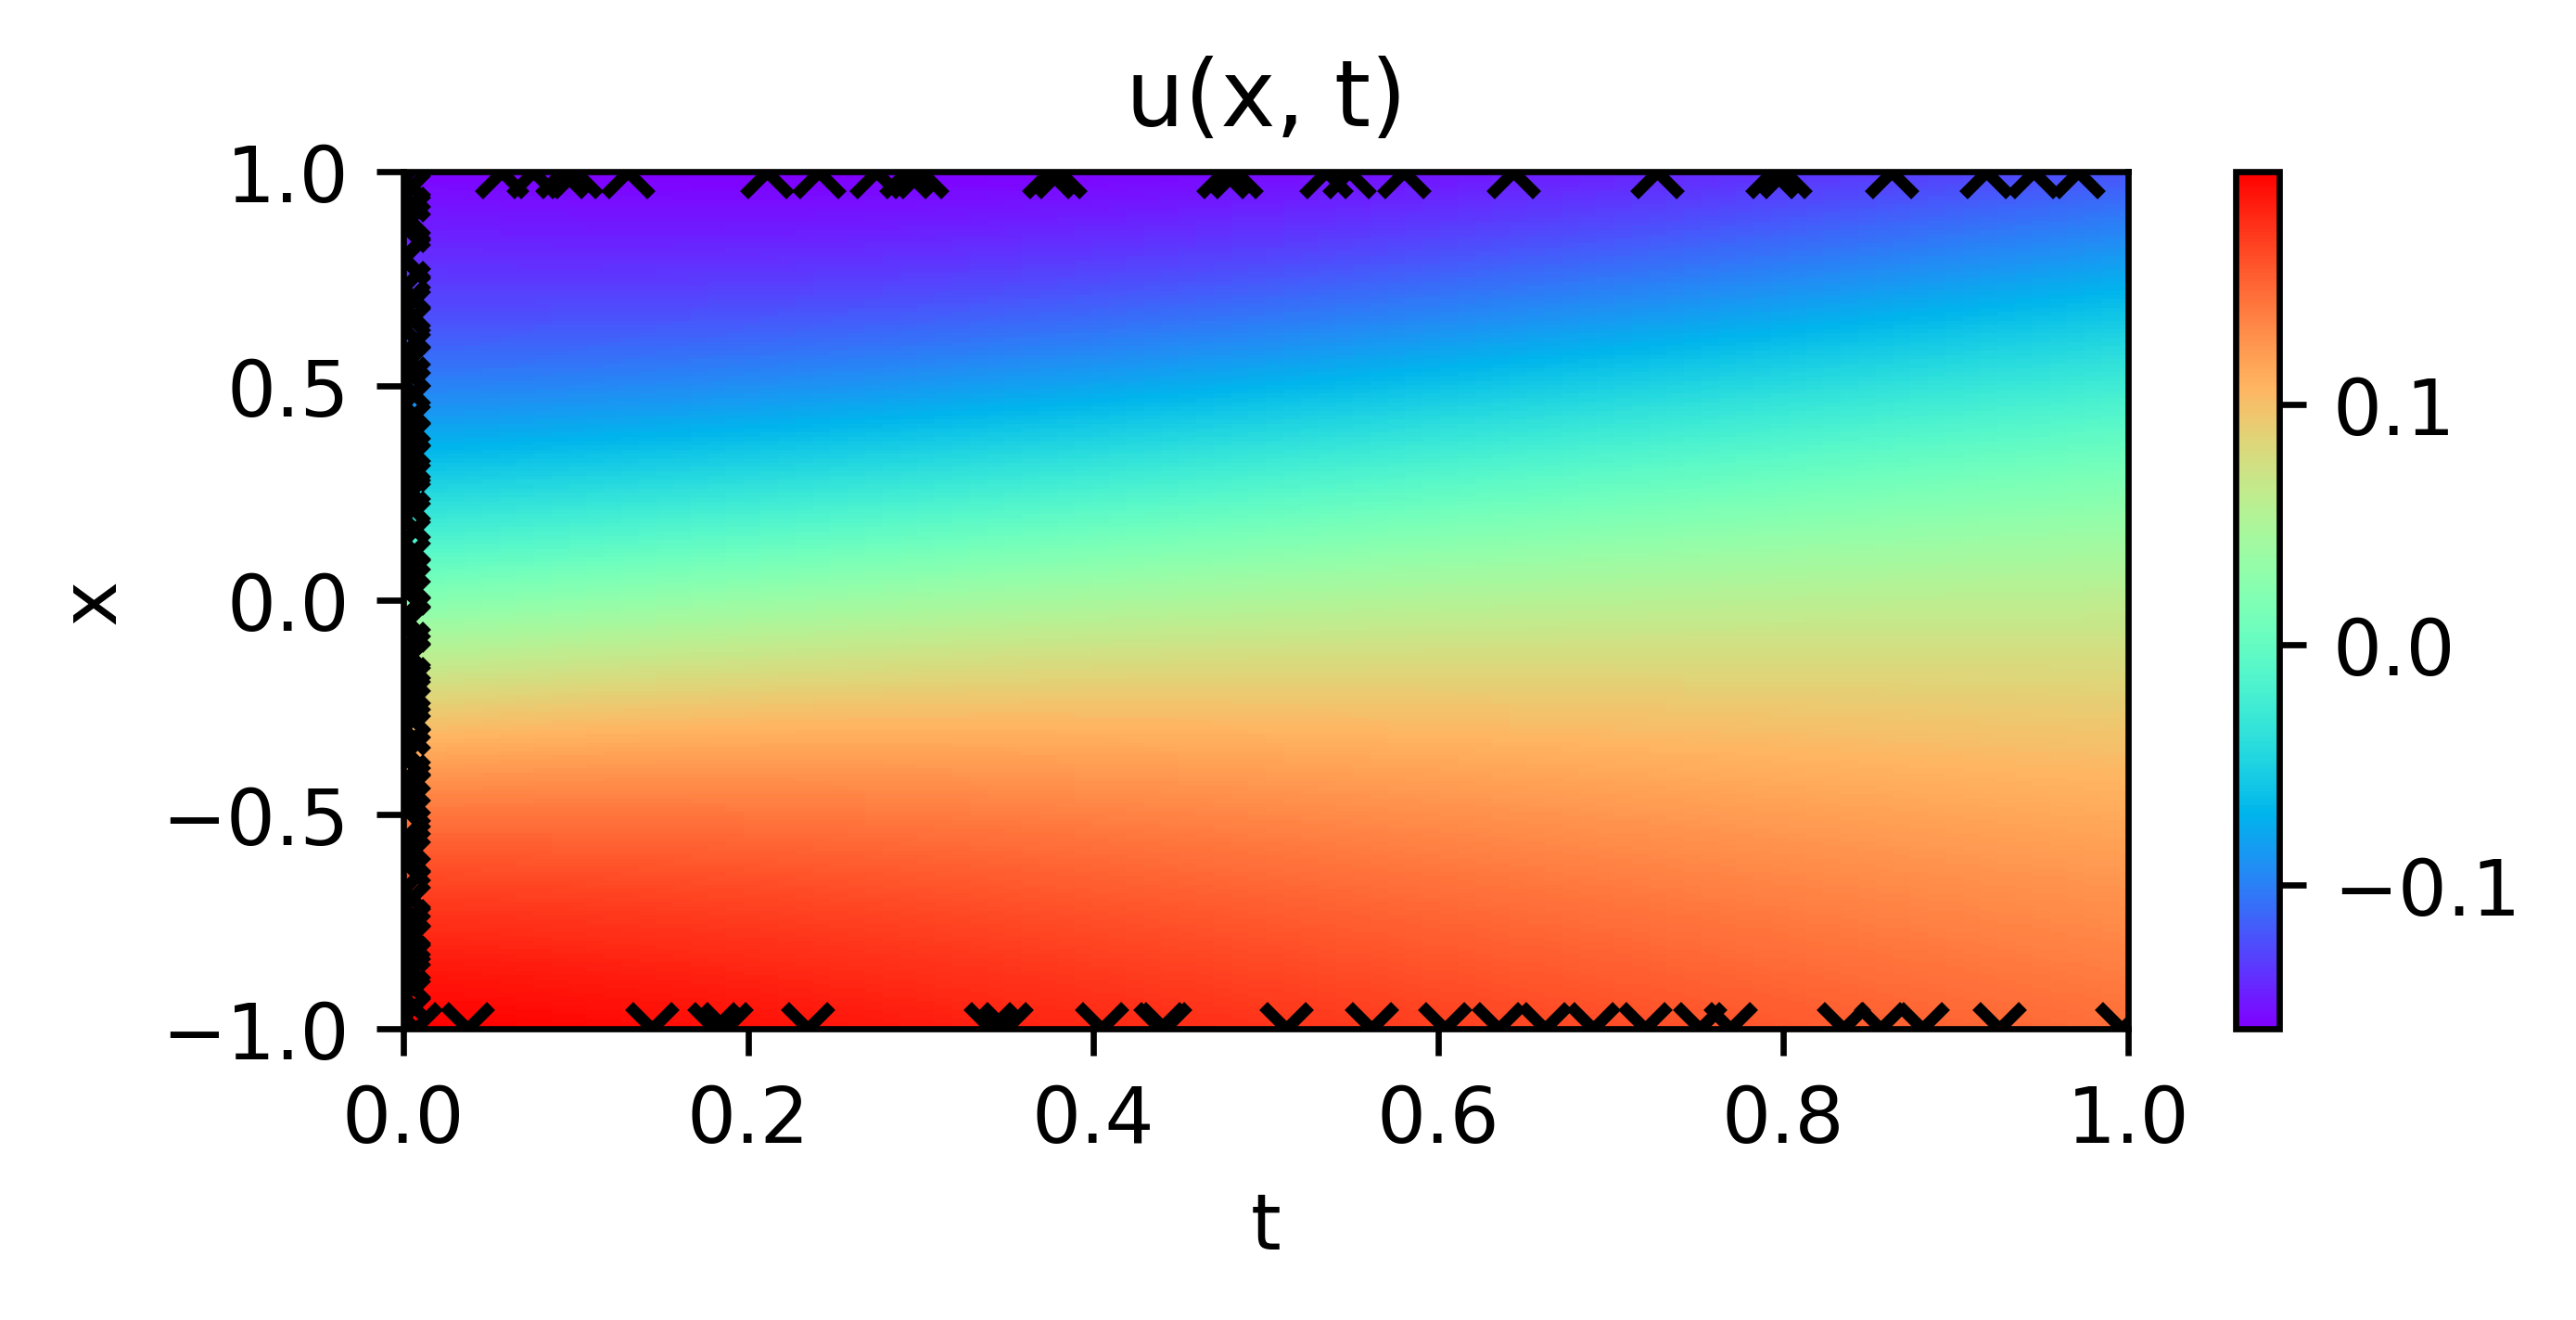

In [ ]:
x = np.expand_dims(np.linspace(-1, +1, 200), axis=1)

plt.figure(figsize=(9, 3), dpi=300)

# 정의된 t 값
time_points = [0.59, 0.79, 0.98]

for i, time_point in enumerate(time_points, start=1):
    t = np.ones_like(x) * time_point  # t 값 생성
    u_values = u(t, x).numpy()       # u(t, x) 계산
    v_values = v(t, x).numpy()       # v(t, x) 계산
    h_abs = np.sqrt(u_values**2 + v_values**2)  # |h(t, x)| 계산
    
    plt.subplot(1, 3, i)
    plt.title(f"t = {time_point}")
    plt.plot(x, h_abs, label="|h(t, x)|")
    plt.ylabel(f"|h(t, x)|")
    plt.xlabel(f"x")
    plt.xlim(-1, +1)
    plt.ylim(0, max(h_abs) * 1.1)  # y 축은 데이터 값보다 약간 크게 설정
    plt.legend()

plt.tight_layout()
plt.savefig("h-vs-x.png")
plt.show()


In [23]:
# save and copy model to drive

model.save("burgers0.h5")
! cp burgers0.h5 drive/MyDrive

'cp'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
